In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import json
import mlp.data_providers as data_providers
from pytorch_mlp_framework.model_architectures import *

/notebooks/mlp/data_providers.py:494: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.set_name is 'train':
/notebooks/mlp/data_providers.py:498: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.set_name is 'val':
/notebooks/mlp/data_providers.py:594: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.set_name is 'train':
/notebooks/mlp/data_providers.py:621: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.set_name is 'val':
/notebooks/mlp/data_providers.py:1239: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.set_name is 'train':
/notebooks/mlp/data_providers.py:1243: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.set_name is 'val':
/notebooks/mlp/data_providers.py:1339: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.set_name is 'train':
/notebooks/mlp/data_providers.py:1366: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.set_name is 'val':


In [3]:
!ls
!touch __init__.py



MLP2022_23_CW2_Spec.pdf  __init__.py		report
README.md		 data			run_vgg_08_default.sh
V88_08_experiment	 install.sh		run_vgg_38_default.sh
VGG_08			 mlp			scripts
VGG_08_experiment	 notebooks		setup.py
VGG_38			 notes
VGG_38_experiment	 pytorch_mlp_framework


In [2]:
class Arguments:
    batch_size = 100
    continue_from_epoch = -1
    seed = 0
    image_num_channels = 3
    image_height = 32
    image_width = 32
    num_stages = 3
    num_blocks_per_stage = 8
    num_filters = 32
    num_epochs = 1
    num_classes = 100
    experiment_name = 'VGG_08_experiment'
    use_gpu = True
    weight_decay_coefficient = 0
    block_type = 'conv_block'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm
import os
import numpy as np
import time

from pytorch_mlp_framework.storage_utils import save_statistics
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 8})

class ExperimentBuilder(nn.Module):
    def __init__(self, network_model, experiment_name, num_epochs, train_data, val_data,
                 test_data, weight_decay_coefficient, use_gpu, continue_from_epoch=-1):
        """
        Initializes an ExperimentBuilder object. Such an object takes care of running training and evaluation of a deep net
        on a given dataset. It also takes care of saving per epoch models and automatically inferring the best val model
        to be used for evaluating the test set metrics.
        :param network_model: A pytorch nn.Module which implements a network architecture.
        :param experiment_name: The name of the experiment. This is used mainly for keeping track of the experiment and creating and directory structure that will be used to save logs, model parameters and other.
        :param num_epochs: Total number of epochs to run the experiment
        :param train_data: An object of the DataProvider type. Contains the training set.
        :param val_data: An object of the DataProvider type. Contains the val set.
        :param test_data: An object of the DataProvider type. Contains the test set.
        :param weight_decay_coefficient: A float indicating the weight decay to use with the adam optimizer.
        :param use_gpu: A boolean indicating whether to use a GPU or not.
        :param continue_from_epoch: An int indicating whether we'll start from scrach (-1) or whether we'll reload a previously saved model of epoch 'continue_from_epoch' and continue training from there.
        """
        super(ExperimentBuilder, self).__init__()


        self.experiment_name = experiment_name
        self.model = network_model

        if torch.cuda.device_count() > 1 and use_gpu:
            self.device = torch.cuda.current_device()
            self.model.to(self.device)
            self.model = nn.DataParallel(module=self.model)
            print('Use Multi GPU', self.device)
        elif torch.cuda.device_count() == 1 and use_gpu:
            self.device =  torch.cuda.current_device()
            self.model.to(self.device)  # sends the model from the cpu to the gpu
            print('Use GPU', self.device)
        else:
            print("use CPU")
            self.device = torch.device('cpu')  # sets the device to be CPU
            print(self.device)

        print('here')

        self.model.reset_parameters()  # re-initialize network parameters
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.all_gradients = []

        print('System learnable parameters')
        num_conv_layers = 0
        num_linear_layers = 0
        total_num_parameters = 0
        for name, value in self.named_parameters():
            print(name, value.shape)
            if all(item in name for item in ['conv', 'weight']):
                num_conv_layers += 1
            if all(item in name for item in ['linear', 'weight']):
                num_linear_layers += 1
            total_num_parameters += np.prod(value.shape)

        print('Total number of parameters', total_num_parameters)
        print('Total number of conv layers', num_conv_layers)
        print('Total number of linear layers', num_linear_layers)

        self.optimizer = optim.Adam(self.parameters(), amsgrad=False,
                                    weight_decay=weight_decay_coefficient)
        self.learning_rate_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer,
                                                                            T_max=num_epochs,
                                                                            eta_min=0.00002)
        # Generate the directory names
        self.experiment_folder = os.path.abspath(experiment_name)
        self.experiment_logs = os.path.abspath(os.path.join(self.experiment_folder, "result_outputs"))
        self.experiment_saved_models = os.path.abspath(os.path.join(self.experiment_folder, "saved_models"))

        # Set best models to be at 0 since we are just starting
        self.best_val_model_idx = 0
        self.best_val_model_acc = 0.

        if not os.path.exists(self.experiment_folder):  # If experiment directory does not exist
            os.mkdir(self.experiment_folder)  # create the experiment directory
            os.mkdir(self.experiment_logs)  # create the experiment log directory
            os.mkdir(self.experiment_saved_models)  # create the experiment saved models directory

        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss().to(self.device)  # send the loss computation to the GPU

        if continue_from_epoch == -2:  # if continue from epoch is -2 then continue from latest saved model
            self.state, self.best_val_model_idx, self.best_val_model_acc = self.load_model(
                model_save_dir=self.experiment_saved_models, model_save_name="train_model",
                model_idx='latest')  # reload existing model from epoch and return best val model index
            # and the best val acc of that model
            self.starting_epoch = int(self.state['model_epoch'])

        elif continue_from_epoch > -1:  # if continue from epoch is greater than -1 then
            self.state, self.best_val_model_idx, self.best_val_model_acc = self.load_model(
                model_save_dir=self.experiment_saved_models, model_save_name="train_model",
                model_idx=continue_from_epoch)  # reload existing model from epoch and return best val model index
            # and the best val acc of that model
            self.starting_epoch = continue_from_epoch
        else:
            self.state = dict()
            self.starting_epoch = 0

    def get_num_parameters(self):
        total_num_params = 0
        for param in self.parameters():
            total_num_params += np.prod(param.shape)

        return total_num_params


    def plot_func_def(self,all_grads, layers):
        
       
        """
        Plot function definition to plot the average gradient with respect to the number of layers in the given model
        :param all_grads: Gradients wrt weights for each layer in the model.
        :param layers: Layer names corresponding to the model parameters
        :return: plot for gradient flow
        """
        plt.plot(all_grads, alpha=0.3, color="b")
        plt.hlines(0, 0, len(all_grads)+1, linewidth=1, color="k" )
        plt.xticks(range(0,len(all_grads), 1), layers, rotation="vertical")
        plt.xlim(xmin=0, xmax=len(all_grads))
        plt.xlabel("Layers")
        plt.ylabel("Average Gradient")
        plt.title("Gradient flow")
        plt.grid(True)
        plt.tight_layout()
        
        return plt
        
    
    def plot_grad_flow(self, named_parameters):
        """
        The function is being called in Line 298 of this file. 
        Receives the parameters of the model being trained. Returns plot of gradient flow for the given model parameters.
       
        """
        all_grads = []
        layers = []

        for name, p in named_parameters:
            if (p.requires_grad) and ("bias" not in name):
                name = name.replace("layer_dict.", "")
                name = name.replace(".weight", "")
                layers.append(name)
                all_grads.append(p.grad.abs().mean().cpu().numpy())
        """
        Complete the code in the block below to collect absolute mean of the gradients for each layer in all_grads with the             layer names in layers.
        """
        ########################################
        
        
        ########################################
            
        
        plt = self.plot_func_def(all_grads, layers)
        
        return plt, all_grads, layers
    
    
    
    
    def run_train_iter(self, x, y):
        
        self.train()  # sets model to training mode (in case batch normalization or other methods have different procedures for training and evaluation)
        x, y = x.float().to(device=self.device), y.long().to(
            device=self.device)  # send data to device as torch tensors
        out = self.model.forward(x)  # forward the data in the model


        loss = F.cross_entropy(input=out, target=y)  # compute loss

        self.optimizer.zero_grad()  # set all weight grads from previous training iters to 0
        loss.backward()  # backpropagate to compute gradients for current iter loss
        
        self.learning_rate_scheduler.step(epoch=self.current_epoch)
        self.optimizer.step()  # update network parameters
        _, predicted = torch.max(out.data, 1)  # get argmax of predictions
        accuracy = np.mean(list(predicted.eq(y.data).cpu()))  # compute accuracy
        return loss.cpu().data.numpy(), accuracy

    def run_evaluation_iter(self, x, y):
        """
        Receives the inputs and targets for the model and runs an evaluation iterations. Returns loss and accuracy metrics.
        :param x: The inputs to the model. A numpy array of shape batch_size, channels, height, width
        :param y: The targets for the model. A numpy array of shape batch_size, num_classes
        :return: the loss and accuracy for this batch
        """
        self.eval()  # sets the system to validation mode
        x, y = x.float().to(device=self.device), y.long().to(
            device=self.device)  # convert data to pytorch tensors and send to the computation device
        out = self.model.forward(x)  # forward the data in the model

        loss = F.cross_entropy(input=out, target=y)  # compute loss

        _, predicted = torch.max(out.data, 1)  # get argmax of predictions
        accuracy = np.mean(list(predicted.eq(y.data).cpu()))  # compute accuracy
        return loss.cpu().data.numpy(), accuracy

    def save_model(self, model_save_dir, model_save_name, model_idx, best_validation_model_idx,
                   best_validation_model_acc):
        """
        Save the network parameter state and current best val epoch idx and best val accuracy.
        :param model_save_name: Name to use to save model without the epoch index
        :param model_idx: The index to save the model with.
        :param best_validation_model_idx: The index of the best validation model to be stored for future use.
        :param best_validation_model_acc: The best validation accuracy to be stored for use at test time.
        :param model_save_dir: The directory to store the state at.
        :param state: The dictionary containing the system state.

        """
        self.state['network'] = self.state_dict()  # save network parameter and other variables.
        self.state['best_val_model_idx'] = best_validation_model_idx  # save current best val idx
        self.state['best_val_model_acc'] = best_validation_model_acc  # save current best val acc
        torch.save(self.state, f=os.path.join(model_save_dir, "{}_{}".format(model_save_name, str(
            model_idx))))  # save state at prespecified filepath

    def load_model(self, model_save_dir, model_save_name, model_idx):
        """
        Load the network parameter state and the best val model idx and best val acc to be compared with the future val accuracies, in order to choose the best val model
        :param model_save_dir: The directory to store the state at.
        :param model_save_name: Name to use to save model without the epoch index
        :param model_idx: The index to save the model with.
        :return: best val idx and best val model acc, also it loads the network state into the system state without returning it
        """
        state = torch.load(f=os.path.join(model_save_dir, "{}_{}".format(model_save_name, str(model_idx))))
        self.load_state_dict(state_dict=state['network'])
        return state, state['best_val_model_idx'], state['best_val_model_acc']

    def run_experiment(self):
        """
        Runs experiment train and evaluation iterations, saving the model and best val model and val model accuracy after each epoch
        :return: The summary current_epoch_losses from starting epoch to total_epochs.
        """
        total_losses = {"train_acc": [], "train_loss": [], "val_acc": [],
                        "val_loss": []}  # initialize a dict to keep the per-epoch metrics
        for i, epoch_idx in enumerate(range(self.starting_epoch, self.num_epochs)):
            epoch_start_time = time.time()
            current_epoch_losses = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []}
            self.current_epoch = epoch_idx
            with tqdm.tqdm(total=len(self.train_data)) as pbar_train:  # create a progress bar for training
                for idx, (x, y) in enumerate(self.train_data):  # get data batches
                    loss, accuracy = self.run_train_iter(x=x, y=y)  # take a training iter step
                    current_epoch_losses["train_loss"].append(loss)  # add current iter loss to the train loss list
                    current_epoch_losses["train_acc"].append(accuracy)  # add current iter acc to the train acc list
                    pbar_train.update(1)
                    pbar_train.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))

            with tqdm.tqdm(total=len(self.val_data)) as pbar_val:  # create a progress bar for validation
                for x, y in self.val_data:  # get data batches
                    loss, accuracy = self.run_evaluation_iter(x=x, y=y)  # run a validation iter
                    current_epoch_losses["val_loss"].append(loss)  # add current iter loss to val loss list.
                    current_epoch_losses["val_acc"].append(accuracy)  # add current iter acc to val acc lst.
                    pbar_val.update(1)  # add 1 step to the progress bar
                    pbar_val.set_description("loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))
            val_mean_accuracy = np.mean(current_epoch_losses['val_acc'])
            if val_mean_accuracy > self.best_val_model_acc:  # if current epoch's mean val acc is greater than the saved best val acc then
                self.best_val_model_acc = val_mean_accuracy  # set the best val model acc to be current epoch's val accuracy
                self.best_val_model_idx = epoch_idx  # set the experiment-wise best val idx to be the current epoch's idx

            for key, value in current_epoch_losses.items():
                total_losses[key].append(np.mean(
                    value))  # get mean of all metrics of current epoch metrics dict, to get them ready for storage and output on the terminal.

            save_statistics(experiment_log_dir=self.experiment_logs, filename='summary.csv',
                            stats_dict=total_losses, current_epoch=i,
                            continue_from_mode=True if (self.starting_epoch != 0 or i > 0) else False)  # save statistics to stats file.

            # load_statistics(experiment_log_dir=self.experiment_logs, filename='summary.csv') # How to load a csv file if you need to

            out_string = "_".join(
                ["{}_{:.4f}".format(key, np.mean(value)) for key, value in current_epoch_losses.items()])
            # create a string to use to report our epoch metrics
            epoch_elapsed_time = time.time() - epoch_start_time  # calculate time taken for epoch
            epoch_elapsed_time = "{:.4f}".format(epoch_elapsed_time)
            print("Epoch {}:".format(epoch_idx), out_string, "epoch time", epoch_elapsed_time, "seconds")
            self.state['model_epoch'] = epoch_idx
            self.save_model(model_save_dir=self.experiment_saved_models,
                            # save model and best val idx and best val acc, using the model dir, model name and model idx
                            model_save_name="train_model", model_idx=epoch_idx,
                            best_validation_model_idx=self.best_val_model_idx,
                            best_validation_model_acc=self.best_val_model_acc)
            self.save_model(model_save_dir=self.experiment_saved_models,
                            # save model and best val idx and best val acc, using the model dir, model name and model idx
                            model_save_name="train_model", model_idx='latest',
                            best_validation_model_idx=self.best_val_model_idx,
                            best_validation_model_acc=self.best_val_model_acc)
            
            ################################################################
            ##### Plot Gradient Flow at each Epoch during Training  ######
            print("Generating Gradient Flow Plot at epoch {}".format(epoch_idx))
            gradient_plt, gradients, layers = self.plot_grad_flow(self.model.named_parameters())
            self.all_gradients.append(
                {
                    "epoch": epoch_idx,
                    "gradients": gradients,
                    "layers": layers
                }
            )
            if not os.path.exists(os.path.join(self.experiment_saved_models, 'gradient_flow_plots')):
                os.mkdir(os.path.join(self.experiment_saved_models, 'gradient_flow_plots'))
                plt.legend(loc="best")

            print('Saving Gradient Flow Plot at epoch {}'.format(epoch_idx))
            gradient_plt.savefig(
                os.path.join(self.experiment_saved_models, 'gradient_flow_plots', "epoch{}.png".format(str(epoch_idx))), 
                dpi=600
            )
            ################################################################
        
        print("Generating test set evaluation metrics")
        self.load_model(model_save_dir=self.experiment_saved_models, model_idx=self.best_val_model_idx,
                        # load best validation model
                        model_save_name="train_model")
        current_epoch_losses = {"test_acc": [], "test_loss": []}  # initialize a statistics dict
        with tqdm.tqdm(total=len(self.test_data)) as pbar_test:  # ini a progress bar
            for x, y in self.test_data:  # sample batch
                loss, accuracy = self.run_evaluation_iter(x=x,
                                                          y=y)  # compute loss and accuracy by running an evaluation step
                current_epoch_losses["test_loss"].append(loss)  # save test loss
                current_epoch_losses["test_acc"].append(accuracy)  # save test accuracy
                pbar_test.update(1)  # update progress bar status
                pbar_test.set_description(
                    "loss: {:.4f}, accuracy: {:.4f}".format(loss, accuracy))  # update progress bar string output

        test_losses = {key: [np.mean(value)] for key, value in
                       current_epoch_losses.items()}  # save test set metrics in dict format
        save_statistics(experiment_log_dir=self.experiment_logs, filename='test_summary.csv',
                        # save test set metrics on disk in .csv format
                        stats_dict=test_losses, current_epoch=0, continue_from_mode=False)

        return total_losses, test_losses, gradient_plt, self.all_gradients


In [6]:
def train_eval_classification_system(args):

    # print all arguments with their values
    rng = np.random.RandomState(seed=args.seed)  # set the seeds for the experiment
    torch.manual_seed(seed=args.seed)  # sets pytorch's seed

# # set up data augmentation transforms for training and testing
    transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    train_data = data_providers.CIFAR100(root='data', set_name='train',
                 transform=transform_train,
                 download=True)  # initialize our rngs using the argument set seed
    val_data = data_providers.CIFAR100(root='data', set_name='val',
                 transform=transform_test,
                 download=True)  # initialize our rngs using the argument set seed
    test_data = data_providers.CIFAR100(root='data', set_name='test',
                 transform=transform_test,
                 download=True)  # initialize our rngs using the argument set seed

    train_data_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, num_workers=4)
    val_data_loader = DataLoader(val_data, batch_size=args.batch_size, shuffle=True, num_workers=4)
    test_data_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=True, num_workers=4)

    if args.block_type == 'conv_block':
        processing_block_type = ConvolutionalProcessingBlock
        dim_reduction_block_type = ConvolutionalDimensionalityReductionBlock
    elif args.block_type == 'empty_block':
        processing_block_type = EmptyBlock
        dim_reduction_block_type = EmptyBlock
    else:
        raise ModuleNotFoundError

    custom_conv_net = ConvolutionalNetwork(
        input_shape=(
            args.batch_size, args.image_num_channels, args.image_height, args.image_width),
        num_output_classes=args.num_classes, num_filters=args.num_filters, use_bias=False,
        num_blocks_per_stage=args.num_blocks_per_stage, num_stages=args.num_stages,
        processing_block_type=processing_block_type,
        dimensionality_reduction_block_type=dim_reduction_block_type)

    print('Setup conv net')

    conv_experiment = ExperimentBuilder(
        network_model=custom_conv_net,
        experiment_name=args.experiment_name,
        num_epochs=args.num_epochs,
        weight_decay_coefficient=args.weight_decay_coefficient,
        use_gpu=args.use_gpu,
        continue_from_epoch=args.continue_from_epoch,
        train_data=train_data_loader, val_data=val_data_loader,
        test_data=test_data_loader
    )

    print('Experiment setup')
    return conv_experiment

In [11]:
# run for vgg 38

def vgg_38_args():
    args = Arguments()
    args.num_epochs= 1
    args.num_stages = 3
    args.num_blocks_per_stage = 5
    args.batch_size = 400
    args.experiment_name = "VGG_38_experiment"
    return args

def vgg_08_args():
    args = Arguments()
    args.num_epochs= 2
    args.num_stages = 3
    args.num_blocks_per_stage = 0
    args.batch_size = 400
    args.experiment_name = "VGG_08_experiment"
    return args

def vgg_38_batch_norm():
    args = vgg_38_args()
    args.block_type = 'dm_conv_block'

In [12]:
args = vgg_38_args_batch_norm()
conv_experiment = train_eval_classification_system(args)


Files already downloaded and verified
train (47500, 32, 32, 3)
train (47500,)
Files already downloaded and verified
val (2500, 32, 32, 3)
val (2500,)
Files already downloaded and verified
test (10000, 32, 32, 3)
test (10000,)
Building basic block of ConvolutionalNetwork using input shape (400, 3, 32, 32)
torch.Size([400, 32, 32, 32])
torch.Size([400, 32, 32, 32])
torch.Size([400, 32, 32, 32])
torch.Size([400, 32, 32, 32])
torch.Size([400, 32, 32, 32])
torch.Size([400, 32, 32, 32])
torch.Size([400, 32, 16, 16])
torch.Size([400, 32, 16, 16])
torch.Size([400, 32, 16, 16])
torch.Size([400, 32, 16, 16])
torch.Size([400, 32, 16, 16])
torch.Size([400, 32, 16, 16])
torch.Size([400, 32, 8, 8])
torch.Size([400, 32, 8, 8])
torch.Size([400, 32, 8, 8])
torch.Size([400, 32, 8, 8])
torch.Size([400, 32, 8, 8])
torch.Size([400, 32, 8, 8])
torch.Size([400, 32, 4, 4])
shape before final linear layer torch.Size([400, 32, 1, 1])
Block is built, output volume is torch.Size([400, 100])
Setup conv net
Use GPU

  0%|          | 0/119 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to r

Epoch 0: train_acc_0.0100_train_loss_4.6093_val_acc_0.0136_val_loss_4.6069 epoch time 8.9899 seconds
Generating Gradient Flow Plot at epoch 0
Saving Gradient Flow Plot at epoch 0
Generating test set evaluation metrics


loss: 4.6009, accuracy: 0.0175: 100%|██████████| 25/25 [00:00<00:00, 31.46it/s]


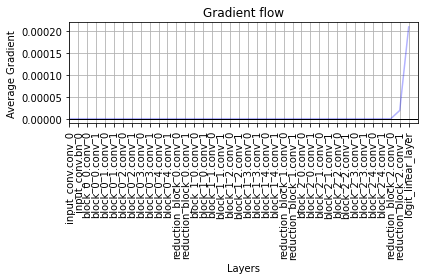

In [13]:
train_loss, test_loss, gradient_plt, all_gradients = conv_experiment.run_experiment()

In [34]:
all_gradients[0].keys()

layers = all_gradients[0]['layers']

output_dict = {}
output_dict['layers'] = layers
for grad in  all_gradients:
    gradient_deserialzied = [float(grad) for grad in grad['gradients']]
    output_dict[f'epoch_{grad["epoch"]}'] = gradient_deserialzied

In [36]:
with open('vgg_38.json', 'w') as fp:
    json.dump(output_dict, fp)